In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kvasir-seg.zip to kvasir-seg.zip


In [ ]:
import zipfile
import os


zip_file_path = "kvasir-seg.zip"
extract_folder = "Kvasir-SEG"


if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)


    print(os.listdir(extract_folder))
else:
    print(f"file {zip_file_path} not exist")



['Kvasir-SEG']


In [ ]:
import os

base_dir = "Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
masks_dir = os.path.join(base_dir, "masks")


if os.path.exists(images_dir) and os.path.exists(masks_dir):
    image_files = os.listdir(images_dir)
    mask_files = os.listdir(masks_dir)

    print(f"Number of images: {len(image_files)}")
    print(f"Number of masks: {len(mask_files)}")
else:
    print(f"Either {images_dir} or {masks_dir} does not exist!")


Number of images: 1000
Number of masks: 1000


In [ ]:
import torch
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


base_dir = "Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
masks_dir = os.path.join(base_dir, "masks")


IMG_SIZE = (224, 224)
BATCH_SIZE = 16


image_paths = sorted([os.path.join(images_dir, fname) for fname in os.listdir(images_dir)])
mask_paths = sorted([os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir)])


assert len(image_paths) == len(mask_paths), "image not equal to mask！"


train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


class KvasirDataset(Dataset):
    def __init__(self, images, masks, transform=None, target_transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)


        image = cv2.resize(image, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)


        image = image / 255.0
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)


        if self.transform:
            image = self.transform(image).to(torch.float32)
        if self.target_transform:
            mask = self.target_transform(mask).to(torch.float32)

        return image, mask


image_transform = transforms.Compose([
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = KvasirDataset(train_images, train_masks, transform=image_transform, target_transform=mask_transform)
val_dataset = KvasirDataset(val_images, val_masks, transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break


Image batch shape: torch.Size([16, 3, 224, 224])
Mask batch shape: torch.Size([16, 1, 224, 224])


In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
import torch


dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

dinov2_vits14.eval()


print(dinov2_vits14)

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 267MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    def __init__(self, backbone, num_classes=2):

        super(SegmentationModel, self).__init__()
        self.backbone = backbone


        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(384, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1),
        )

    def forward(self, x):


        x = self.backbone(x).to(torch.float32)
        # print(f"Backbone output shape: {x.shape}")

        batch_size = x.shape[0]
        embedding_dim = x.shape[1]
        features_2d = x.view(batch_size, embedding_dim, 1, 1)

        output = F.interpolate(self.upsample(features_2d), size=(224, 224), mode="bilinear", align_corners=False)
        # print(f"Segmentation output shape: {output.shape}")

        return output





In [ ]:
def calculate_iou(pred_mask, true_mask):
    intersection = (pred_mask & true_mask).float().sum()
    union = (pred_mask | true_mask).float().sum()
    return intersection / union if union > 0 else torch.tensor(0.0, device=pred_mask.device)



In [ ]:
def fine_tune_model(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"


    for name, param in model.named_parameters():
        if "backbone" in name:
            param.requires_grad = False

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


    train_losses = []
    val_ious = []

    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device).float(), masks.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.squeeze(1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()


        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss:.4f}")


        model.eval()
        with torch.no_grad():
            total_iou = 0.0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long()
                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1)
                iou = calculate_iou(predictions, masks.squeeze(1))
                total_iou += iou


            avg_val_iou = total_iou / len(val_loader)
            val_ious.append(avg_val_iou)
            print(f"Validation IoU: {avg_val_iou:.4f}")

    return model, train_losses, val_ious


In [ ]:
def visualize_training_results(train_losses, val_ious):

    if isinstance(train_losses[0], torch.Tensor):
        train_losses = [loss.cpu().item() for loss in train_losses]
    if isinstance(val_ious[0], torch.Tensor):
        val_ious = [iou.cpu().item() for iou in val_ious]

    epochs = range(1, len(train_losses) + 1)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_ious, marker='o', color='green', label='Validation IoU')
    plt.title('Validation IoU Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()


    plt.tight_layout()
    plt.show()


In [ ]:
def calculate_metrics(predictions, targets):

    intersection = (predictions & targets).sum().float()
    union = (predictions | targets).sum().float()
    true_positive = intersection
    false_positive = (predictions & ~targets).sum().float()
    false_negative = (~predictions & targets).sum().float()

    # IoU
    iou = (intersection / union) if union > 0 else 0.0
    # Precision
    precision = (true_positive / (true_positive + false_positive)) if (true_positive + false_positive) > 0 else 0.0
    # Recall
    recall = (true_positive / (true_positive + false_negative)) if (true_positive + false_negative) > 0 else 0.0
    # F1-Score
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return iou, precision, recall, f1_score


def inference_and_evaluate(model, val_loader, device=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    total_iou = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_f1_score = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.squeeze(1).long().to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1).bool()
            masks = masks.bool()


            iou, precision, recall, f1_score = calculate_metrics(predictions, masks)
            total_iou += iou
            total_precision += precision
            total_recall += recall
            total_f1_score += f1_score


    num_batches = len(val_loader)
    avg_iou = total_iou / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1_score = total_f1_score / num_batches


    print(f"Final IoU: {avg_iou:.4f}")
    print(f"Final Precision: {avg_precision:.4f}")
    print(f"Final Recall: {avg_recall:.4f}")
    print(f"Final F1-Score: {avg_f1_score:.4f}")

    return avg_iou, avg_precision, avg_recall, avg_f1_score




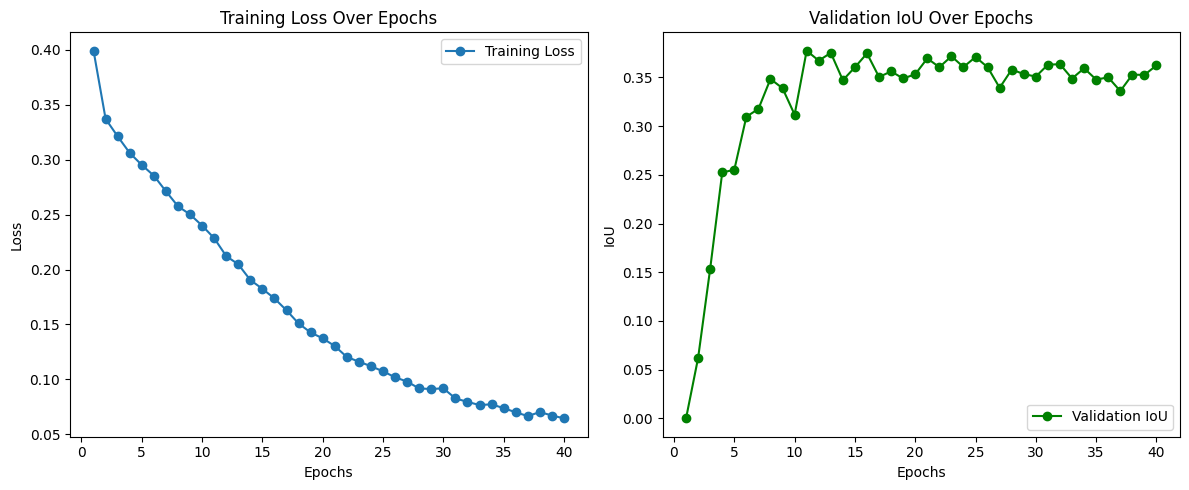

Final IoU: 0.3623
Final Precision: 0.5614
Final Recall: 0.4963
Final F1-Score: 0.5239


(tensor(0.3623, device='cuda:0'),
 tensor(0.5614, device='cuda:0'),
 tensor(0.4963, device='cuda:0'),
 tensor(0.5239, device='cuda:0'))

In [ ]:
visualize_training_results(train_losses, val_ious)
inference_and_evaluate(fine_tuned_model, val_loader)

Epoch 1/40, Loss: 0.3993
Validation IoU: 0.0000
Epoch 2/40, Loss: 0.3372
Validation IoU: 0.0620
Epoch 3/40, Loss: 0.3213
Validation IoU: 0.1535
Epoch 4/40, Loss: 0.3062
Validation IoU: 0.2524
Epoch 5/40, Loss: 0.2952
Validation IoU: 0.2551
Epoch 6/40, Loss: 0.2855
Validation IoU: 0.3096
Epoch 7/40, Loss: 0.2713
Validation IoU: 0.3176
Epoch 8/40, Loss: 0.2576
Validation IoU: 0.3484
Epoch 9/40, Loss: 0.2502
Validation IoU: 0.3388
Epoch 10/40, Loss: 0.2400
Validation IoU: 0.3118
Epoch 11/40, Loss: 0.2285
Validation IoU: 0.3774
Epoch 12/40, Loss: 0.2122
Validation IoU: 0.3672
Epoch 13/40, Loss: 0.2047
Validation IoU: 0.3752
Epoch 14/40, Loss: 0.1904
Validation IoU: 0.3471
Epoch 15/40, Loss: 0.1824
Validation IoU: 0.3604
Epoch 16/40, Loss: 0.1736
Validation IoU: 0.3746
Epoch 17/40, Loss: 0.1628
Validation IoU: 0.3504
Epoch 18/40, Loss: 0.1509
Validation IoU: 0.3562
Epoch 19/40, Loss: 0.1427
Validation IoU: 0.3489
Epoch 20/40, Loss: 0.1373
Validation IoU: 0.3532
Epoch 21/40, Loss: 0.1303
Val

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

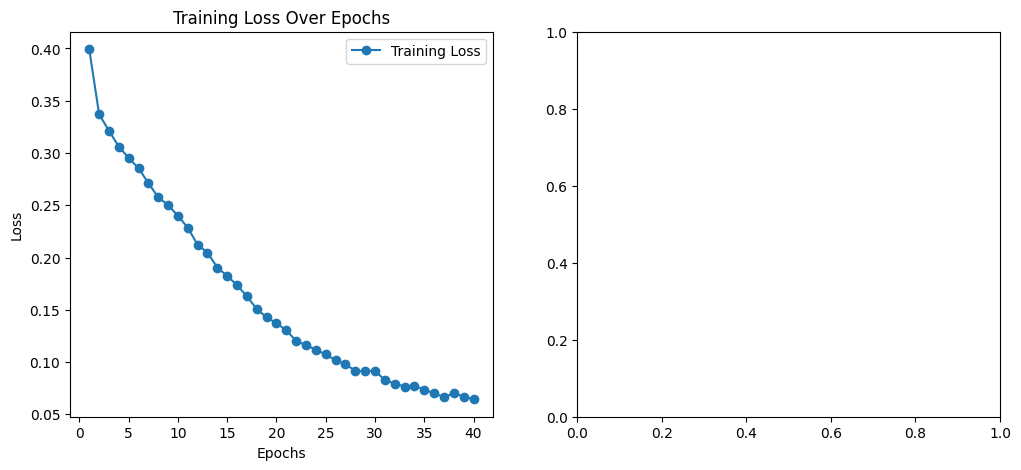

In [ ]:

model = SegmentationModel(dinov2_vits14)

fine_tuned_model, train_losses, val_ious = fine_tune_model(
    model, train_loader, val_loader, num_epochs=40, learning_rate=5e-4
)


visualize_training_results(train_losses, val_ious)
inference_and_evaluate(fine_tuned_model, val_loader)

